In [1]:
import os ,sys 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/Users/barradd/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [79]:
# !pip install tensorflow==1.9.0
keras.backend.clear_session()

In [43]:
np.random.seed(101)
# tf.set_random_seed(303)

In [44]:
print (tf.__version__)
print (keras.__version__)

1.9.0
2.1.6-tf


In [5]:
df = pd.read_csv('SubCh1_TrainingData.csv')

In [6]:
df.set_index("Sample_Name",inplace=True)

In [7]:
df_edit = pd.concat( [df, pd.get_dummies(df["Treatment"]),pd.get_dummies( df["Timepoint"])]
                         ,axis=1,sort=True )

In [8]:
df = df_edit.drop(["Treatment","Timepoint","BioRep","Isolate"],axis=1)

In [9]:
y = df["DHA_IC50"]
X = df.drop("DHA_IC50",axis=1)

In [10]:
# for m in df.columns:
#     print (m,df[df[m].isna()].shape[0])
sc = StandardScaler()

In [11]:
Xsc = sc.fit_transform(X)

/Users/barradd/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/barradd/anaconda2/lib/python2.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [12]:
X_train, X_test, y_train, y_test = train_test_split(Xsc, y,
                                                    test_size=0.3,
                                                    random_state=101)

In [13]:
X_train.shape[1]

5544

In [14]:
def build_model():
    model = keras.Sequential([
    layers.Dense(640, activation=tf.nn.relu, input_shape=[X_train.shape[1]]),
    layers.Dense(640, activation=tf.nn.relu),
        layers.Dense(640, activation=tf.nn.relu),
        layers.Dense(640, activation=tf.nn.relu),
        layers.Dense(640, activation=tf.nn.relu),
   # layers.Dense(64, activation=tf.nn.relu),
    #layers.Dense(64, activation=tf.nn.relu),
#         layers.Dense(128, activation=tf.nn.relu),
#         layers.Dense(128, activation=tf.nn.relu),
#         layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [87]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 640)               3548800   
_________________________________________________________________
dense_11 (Dense)             (None, 640)               410240    
_________________________________________________________________
dense_12 (Dense)             (None, 640)               410240    
_________________________________________________________________
dense_13 (Dense)             (None, 640)               410240    
_________________________________________________________________
dense_14 (Dense)             (None, 640)               410240    
_________________________________________________________________
dense_15 (Dense)             (None, 64)                41024     
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
__________

In [16]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('.')
            #print('.', end='')

EPOCHS = 1000

# history = model.fit(
#   X_train, y_train,
#   epochs=EPOCHS, validation_split = 0.2, verbose=0,
#   callbacks=[PrintDot()])

In [17]:
# hist = pd.DataFrame(history.history)
# hist['epoch'] = history.epoch
# hist.tail()

In [18]:
def plot_history(history):
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MAE]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#     plt.ylim([0,5])
    plt.ylim([0,2])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
#     plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.ylabel('Mean Square Error [MSE]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#     plt.ylim([0,20])
    plt.ylim([0,5])
    plt.legend()
    plt.show()


#plot_history(history)

In [19]:
# model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# history = model.fit(X_train, y_train, epochs=1000,batch_size=2,
#                     validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])


# plot_history(history)

In [98]:
history = model.fit(X_train, y_train, epochs=1000,batch_size=2,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

.


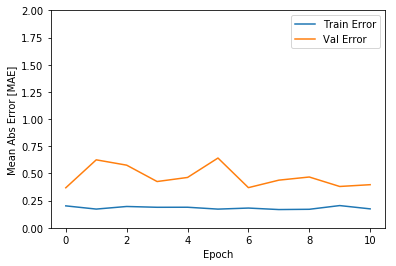

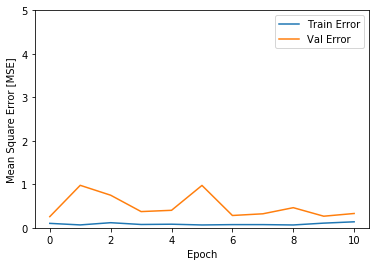

In [99]:
plot_history(history)
# plt.savefig("learning_curves_TF.png",format="png")

In [100]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MAE".format(mae))

Testing set Mean Abs Error:  0.54 MAE


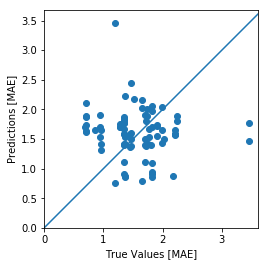

In [101]:
test_predictions = model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MAE]')
plt.ylabel('Predictions [MAE]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
# plt.savefig("MAE_scatter_TF.svg",format="svg")
plt.show()


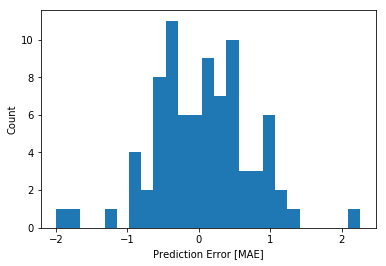

In [102]:
error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MAE]")
_ = plt.ylabel("Count")
# plt.savefig("MAE_hist_TF.svg",format="svg")
plt.show()


In [75]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [76]:
print ("R^2:",r2_score(y_test, test_predictions))
print ("MAE:",mean_absolute_error(y_test, test_predictions))
print ("MSE:",mean_squared_error(y_test, test_predictions))

('R^2:', -0.4556839716373895)
('MAE:', 0.46696547512194003)
('MSE:', 0.3788374540447253)


In [77]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features).flatten()
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [103]:
base_accuracy = evaluate(model, X_test, y_test)

Model Performance
Average Error: 0.5358 degrees.
Accuracy = 58.15%.


In [29]:
# model.save("my_TF1.9_model_copy_2.h5")
# model.save("my_TF1.9_model_copy_73acc.h5")

In [30]:
model.weighted_metrics


In [31]:
model.get_weights()[0].size

3548160

In [32]:
len(X_test) , X_test.shape

(82, (82, 5544))

In [33]:
len(X_train) , X_train.shape

(190, (190, 5544))

In [34]:
##https://stackoverflow.com/questions/44119207/is-there-any-way-to-get-variable-importance-with-keras

In [35]:
# !pip install eli5

In [36]:
# from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,classification_report, confusion_matrix,accuracy_score,matthews_corrcoef
# import eli5
# from sklearn.metrics import fbeta_score, make_scorer
# from eli5.sklearn import PermutationImportance

In [37]:
# ftwo_scorer = make_scorer(accuracy_score)


In [38]:
# perm = PermutationImportance(model, random_state=np.random.seed(101),scoring=ftwo_scorer).fit(X_train,y_train)

In [39]:
# eli5.show_weights(perm, feature_names = X.columns.tolist())

In [40]:
# for n in y_test:
# print (y_test)

In [41]:
# test_predictions

# from tf.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

my_model = KerasRegressor(build_fn=build_model)  

history2 = my_model.fit(X_train, y_train, epochs=1000,batch_size=2,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history2)

perm = PermutationImportance(my_model, random_state=np.random.seed(101),n_iter=1).fit(X_train, y_train)
#


test_predictions2 = my_model.predict(X_test)
# test_predictions2 = perm.predict(X_test).flatten()

plt.scatter(y_test, test_predictions2)
plt.xlabel('True Values [MAE]')
plt.ylabel('Predictions [MAE]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


error = test_predictions2 - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MAE]")
_ = plt.ylabel("Count")
plt.show()

base_accuracy = evaluate(my_model, X_test, y_test)

print ("R^2:",r2_score(y_test, test_predictions2))
print ("MAE:",mean_absolute_error(y_test, test_predictions2))
print ("MSE:",mean_squared_error(y_test, test_predictions2))


my_results = eli5.show_weights(perm, feature_names = X.columns.tolist(),top=50)

# type(my_results)

my_results

Weight	Feature
0.0008 ± 0.0000	PF3D7_0520900
0.0006 ± 0.0000	PF3D7_0933600
0.0005 ± 0.0000	PF3D7_1415100
0.0005 ± 0.0000	PF3D7_0514000
0.0005 ± 0.0000	PF3D7_0609900
0.0005 ± 0.0000	PF3D7_1421000
0.0004 ± 0.0000	PF3D7_1345700
0.0004 ± 0.0000	PF3D7_0405700
0.0004 ± 0.0000	PF3D7_1478700
0.0004 ± 0.0000	PF3D7_0401700
0.0004 ± 0.0000	PF3D7_1346200
0.0004 ± 0.0000	PF3D7_1464200
0.0004 ± 0.0000	PF3D7_0931900
0.0004 ± 0.0000	PF3D7_1338100
0.0004 ± 0.0000	PF3D7_0812200
0.0004 ± 0.0000	MAL6.1339986.1340131..c..r
0.0004 ± 0.0000	PF3D7_1439700
0.0004 ± 0.0000	PF3D7_1130200
0.0003 ± 0.0000	PF3D7_1431200
0.0003 ± 0.0000	PF3D7_0626800
0.0003 ± 0.0000	PF3D7_1344100
0.0003 ± 0.0000	PF3D7_1343000
0.0003 ± 0.0000	PF3D7_0502500
0.0003 ± 0.0000	PF3D7_1250700
0.0003 ± 0.0000	PF3D7_1219800
0.0003 ± 0.0000	PF3D7_0613000.1
0.0003 ± 0.0000	PF3D7_1455100
0.0003 ± 0.0000	PF3D7_1454900
0.0003 ± 0.0000	PF3D7_0304700
0.0003 ± 0.0000	PF3D7_1446100
0.0003 ± 0.0000	PF3D7_1254300
0.0003 ± 0.0000	PF3D7_1206400
0.0003 ± 0.0000	PF3D7_0709800
0.0003 ± 0.0000	PF3D7_0729700
0.0003 ± 0.0000	PF3D7_0630100
0.0003 ± 0.0000	PF3D7_1328100
0.0003 ± 0.0000	PF3D7_1131600
0.0003 ± 0.0000	PF3D7_0617100
0.0003 ± 0.0000	PF3D7_1217000
0.0003 ± 0.0000	PF3D7_1453700
0.0003 ± 0.0000	PF3D7_1412800
0.0003 ± 0.0000	PF3D7_0917200
0.0003 ± 0.0000	PF3D7_1208900
0.0003 ± 0.0000	PF3D7_0523100
0.0003 ± 0.0000	PF3D7_0418700
0.0003 ± 0.0000	MAL14.2495738.2496264....k
0.0003 ± 0.0000	PF3D7_0206800
0.0003 ± 0.0000	PF3D7_1245200
0.0003 ± 0.0000	PF3D7_0112800
0.0003 ± 0.0000	PF3D7_1474100
… 5494 more …
perm, feature_names = X.columns.tolist()
my_results = eli5.show_weights(p

perm = PermutationImportance(model, random_state=np.random.seed(101),n_iter=1).fit(X_train, y_train)

type(my_model)

type(model)

